In [1]:
import keras
keras.__version__

/home/leechan/anaconda3/envs/DLCNN/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

In [2]:
from keras.applications.inception_v3 import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(299, 299, 3))

In [3]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base'
train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')

test_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base/test_dir'

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 15

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

def extract_features_test(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode=None)
    i = 0
    for inputs_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features

test_features = extract_features_test(test_dir, 12500)
train_features, train_labels = extract_features(train_dir, 20000)
validation_features, validation_labels = extract_features(validation_dir, 5000)

Found 12500 images belonging to 1 classes.
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (20000, 1 * 1 * 2048))
validation_features = np.reshape(validation_features, (5000, 1 * 1 * 2048))
test_features = np.reshape(test_features, (12500, 1 * 1 * 2048))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_dim=1 * 1 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [7]:
history = model.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=120,
                    validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 1s 39us/step - loss: 0.7320 - acc: 0.5094 - val_loss: 0.6769 - val_acc: 0.5852
Epoch 2/100
20000/20000 [==============================] - 1s 27us/step - loss: 0.7043 - acc: 0.5428 - val_loss: 0.6671 - val_acc: 0.6110
Epoch 3/100
20000/20000 [==============================] - 1s 28us/step - loss: 0.6945 - acc: 0.5481 - val_loss: 0.6620 - val_acc: 0.5998
Epoch 4/100
20000/20000 [==============================] - 1s 36us/step - loss: 0.6828 - acc: 0.5659 - val_loss: 0.6579 - val_acc: 0.6058
Epoch 5/100
20000/20000 [==============================] - 1s 36us/step - loss: 0.6744 - acc: 0.5789 - val_loss: 0.6547 - val_acc: 0.6118
Epoch 6/100
20000/20000 [==============================] - 1s 26us/step - loss: 0.6706 - acc: 0.5843 - val_loss: 0.6524 - val_acc: 0.6228
Epoch 7/100
20000/20000 [==============================] - 1s 27us/step - loss: 0.6627 - acc: 0.6007 - val_loss: 0.6517 - v

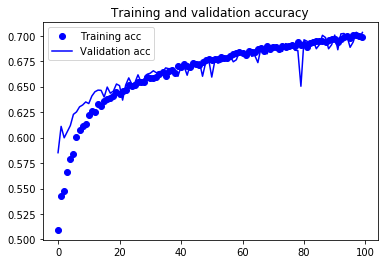

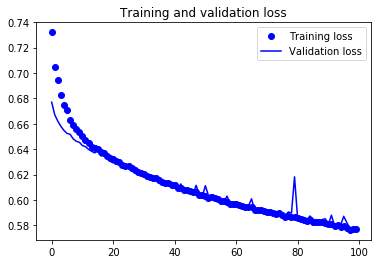

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [1]:
from keras.preprocessing import image
from keras.models import Model 
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras import backend as K

x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=conv_base.input, outputs=predictions)

/home/leechan/anaconda3/envs/DLCNN/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


NameError: name 'conv_base' is not defined

In [6]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 192


In [7]:
for layer in conv_base.layers:
    layer.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(299, 299),
        batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=50,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [10]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=400,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=100,
      verbose=2)

Epoch 1/30
 - 517s - loss: 0.2763 - acc: 0.9045 - val_loss: 0.1150 - val_acc: 0.9598
Epoch 2/30
 - 466s - loss: 0.1551 - acc: 0.9410 - val_loss: 0.0972 - val_acc: 0.9666
Epoch 3/30
 - 463s - loss: 0.1391 - acc: 0.9468 - val_loss: 0.0509 - val_acc: 0.9832
Epoch 4/30
 - 463s - loss: 0.1383 - acc: 0.9435 - val_loss: 0.1243 - val_acc: 0.9560
Epoch 5/30
 - 466s - loss: 0.1316 - acc: 0.9485 - val_loss: 0.0958 - val_acc: 0.9696
Epoch 6/30
 - 458s - loss: 0.1301 - acc: 0.9470 - val_loss: 0.1267 - val_acc: 0.9564
Epoch 7/30
 - 459s - loss: 0.1259 - acc: 0.9521 - val_loss: 0.1457 - val_acc: 0.9484
Epoch 8/30
 - 461s - loss: 0.1247 - acc: 0.9499 - val_loss: 0.1000 - val_acc: 0.9682
Epoch 9/30
 - 457s - loss: 0.1241 - acc: 0.9503 - val_loss: 0.0778 - val_acc: 0.9760
Epoch 10/30
 - 458s - loss: 0.1229 - acc: 0.9520 - val_loss: 0.0861 - val_acc: 0.9738
Epoch 11/30
 - 459s - loss: 0.1221 - acc: 0.9532 - val_loss: 0.1160 - val_acc: 0.9630
Epoch 12/30
 - 462s - loss: 0.1248 - acc: 0.9507 - val_loss: 0.

In [11]:
model.save('InceptionV3_feature_extraction.h5')

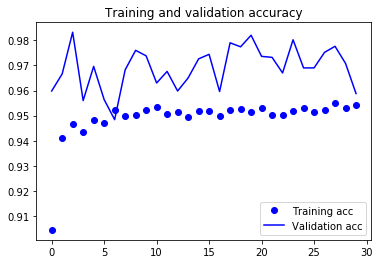

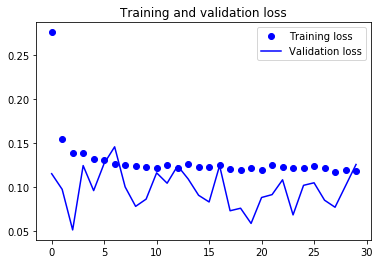

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

activation_46 (Activation)      (None, 17, 17, 160)  0           batch_normalization_46[0][0]     
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 17, 17, 160)  122880      mixed4[0][0]                     
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 17, 17, 160)  179200      activation_46[0][0]              
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 17, 17, 160)  480         conv2d_42[0][0]                  
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 17, 17, 160)  480         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation

batch_normalization_63 (BatchNo (None, 17, 17, 192)  576         conv2d_63[0][0]                  
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 17, 17, 192)  576         conv2d_68[0][0]                  
__________________________________________________________________________________________________
activation_63 (Activation)      (None, 17, 17, 192)  0           batch_normalization_63[0][0]     
__________________________________________________________________________________________________
activation_68 (Activation)      (None, 17, 17, 192)  0           batch_normalization_68[0][0]     
__________________________________________________________________________________________________
average_pooling2d_7 (AveragePoo (None, 17, 17, 768)  0           mixed6[0][0]                     
__________________________________________________________________________________________________
conv2d_61 

conv2d_91 (Conv2D)              (None, 8, 8, 384)    1548288     activation_90[0][0]              
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, 8, 8, 384)    1152        conv2d_87[0][0]                  
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, 8, 8, 384)    1152        conv2d_91[0][0]                  
__________________________________________________________________________________________________
activation_87 (Activation)      (None, 8, 8, 384)    0           batch_normalization_87[0][0]     
__________________________________________________________________________________________________
activation_91 (Activation)      (None, 8, 8, 384)    0           batch_normalization_91[0][0]     
__________________________________________________________________________________________________
conv2d_88 

In [16]:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=400,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=100)

Epoch 1/100
400/400 [==============================] - 492s 1s/step - loss: 0.0992 - acc: 0.9622 - val_loss: 0.0292 - val_acc: 0.9912
Epoch 2/100
400/400 [==============================] - 473s 1s/step - loss: 0.0776 - acc: 0.9690 - val_loss: 0.0274 - val_acc: 0.9910
Epoch 3/100
400/400 [==============================] - 474s 1s/step - loss: 0.0701 - acc: 0.9731 - val_loss: 0.0235 - val_acc: 0.9924
Epoch 4/100
400/400 [==============================] - 487s 1s/step - loss: 0.0582 - acc: 0.9773 - val_loss: 0.0293 - val_acc: 0.9912
Epoch 5/100
400/400 [==============================] - 487s 1s/step - loss: 0.0573 - acc: 0.9788 - val_loss: 0.0266 - val_acc: 0.9924
Epoch 6/100
400/400 [==============================] - 488s 1s/step - loss: 0.0529 - acc: 0.9789 - val_loss: 0.0240 - val_acc: 0.9926
Epoch 7/100
400/400 [==============================] - 490s 1s/step - loss: 0.0465 - acc: 0.9827 - val_loss: 0.0314 - val_acc: 0.9912
Epoch 8/100
400/400 [==============================] - 488s 1s

Epoch 62/100
400/400 [==============================] - 445s 1s/step - loss: 0.0078 - acc: 0.9977 - val_loss: 0.0490 - val_acc: 0.9940
Epoch 63/100
400/400 [==============================] - 449s 1s/step - loss: 0.0062 - acc: 0.9979 - val_loss: 0.0446 - val_acc: 0.9946
Epoch 64/100
400/400 [==============================] - 453s 1s/step - loss: 0.0064 - acc: 0.9975 - val_loss: 0.0613 - val_acc: 0.9918
Epoch 65/100
400/400 [==============================] - 508s 1s/step - loss: 0.0058 - acc: 0.9979 - val_loss: 0.0503 - val_acc: 0.9936
Epoch 66/100
400/400 [==============================] - 477s 1s/step - loss: 0.0066 - acc: 0.9979 - val_loss: 0.0479 - val_acc: 0.9942
Epoch 67/100
400/400 [==============================] - 480s 1s/step - loss: 0.0076 - acc: 0.9977 - val_loss: 0.0526 - val_acc: 0.9930
Epoch 68/100
400/400 [==============================] - 486s 1s/step - loss: 0.0081 - acc: 0.9975 - val_loss: 0.0585 - val_acc: 0.9922
Epoch 69/100
400/400 [==============================] -

In [18]:
model.save('InceptionV3_Finetuning.h5')

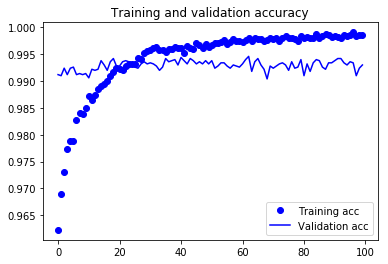

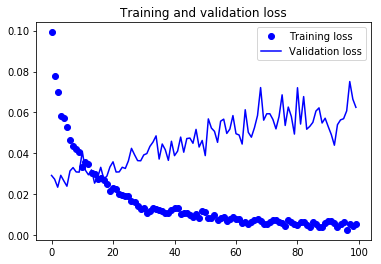

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

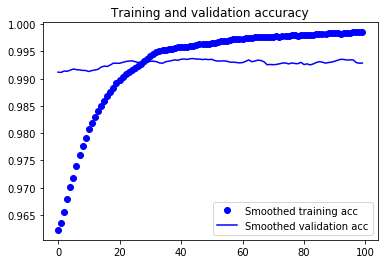

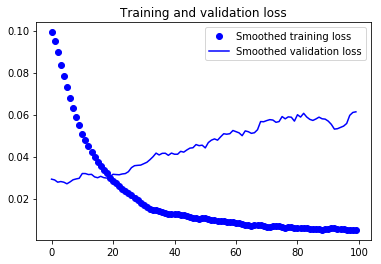

In [20]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()